In [1]:
# https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
# https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv # not labeled not used
# techniques: few-shot learning, weighted cross entropy, upsampling/downsampling, focal loss
# metrics: precision, recall, PR curve
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("./train.csv")
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_train, df_val = df.loc[:int(0.8*len(df))], df.loc[int(0.8*len(df)):]
df_train.shape, df_val.shape

((33601, 785), (8400, 785))

In [4]:
len(df_train[df_train['label']==0]), len(df_train[df_train['label']==1]), len(df_val[df_val['label']==0]), len(df_val[df_val['label']==1])

(3281, 3734, 852, 950)

(3281, 785) (32, 785) 3313


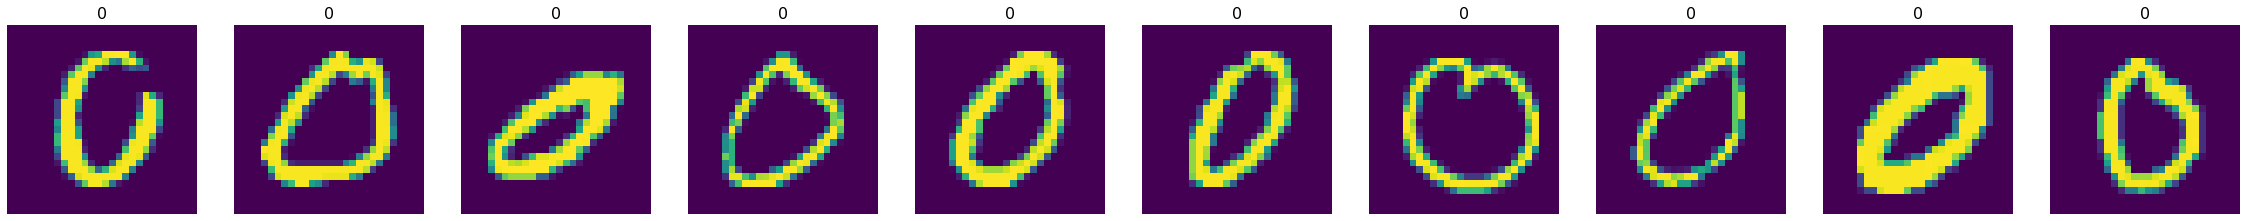

(852, 785) (8, 785) 860


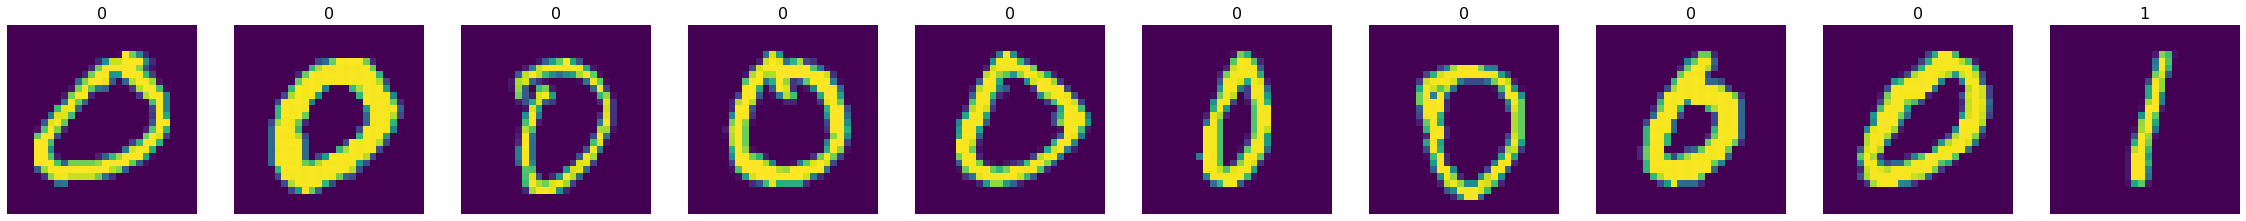

In [5]:
class MnistDataset(Dataset):
    def __init__(self, csvPath, mode="train"):
        df = pd.read_csv(csvPath)
        df = df.loc[:int(0.8*len(df))] if mode=="train" else df.loc[int(0.8*len(df)):]
        self.df0 = df[df['label']==0].reset_index(drop=True)
        self.df1 = df[df['label']==1][:int(0.01*len(self.df0))].reset_index(drop=True)
        self.R = list(range(len(self.df0)+len(self.df1)))
        random.shuffle(self.R)
        print(self.df0.shape, self.df1.shape, len(self))
        
    def __len__(self):
        return len(self.R)
    
    def __getitem__(self, index):
        is0, idx = self.R[index]<len(self.df0), self.R[index]%len(self.df0)
        if is0:
            img   = self.df0.loc[idx][1:].to_numpy().reshape(1,28,28) / 255.
            yTrue = 0
        else:
            img   = self.df1.loc[idx][1:].to_numpy().reshape(1,28,28) / 255.
            yTrue = 1
        return torch.Tensor(img), torch.Tensor([yTrue]).type(torch.int64)
    
    def showExamples(self):
        plt.figure(figsize=(4*10,4))
        for i in range(10):
            img, yTrue = self.__getitem__(i)
            plt.subplot(1,10,i+1)
            plt.title(int(yTrue),fontsize=16)
            plt.imshow(img.detach().numpy().squeeze(0))
            plt.axis('off')
        plt.show()
        
trainDataset = MnistDataset("./train.csv")
trainDataset.showExamples()
valDataset = MnistDataset("./train.csv", mode="val")
valDataset.showExamples()

In [32]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1   = nn.ReLU()
        self.maxpool1= nn.MaxPool2d(2)
        self.conv2   = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2   = nn.ReLU()
        self.maxpool2= nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dense1  = nn.Linear(7*7*64, 64)
        self.dense2  = nn.Linear(64, 64)
        self.dense3  = nn.Linear(64, 2)
        # don't do softmax, since nn.functional.CrossEntropyLoss will do
    def forward(self, x): # (bz,1,28,28)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x) # (bz,64,14,14)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x) # (bz,64,7,7)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

model = Model().to('cuda')
# print( sum( parameter.numel() for parameter in model.parameters() ) ) # type: torch.nn.parameter.Parameter
model(torch.rand(1,1,28,28).to('cuda'))

tensor([[0.0565, 0.1409]], device='cuda:0', grad_fn=<AddmmBackward>)

In [33]:
trainDataLoader = DataLoader(trainDataset, batch_size=64)
valDataLoader   = DataLoader(valDataset, batch_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#loss_func = nn.CrossEntropyLoss() # yPred:float32 non-softmax (B,D), yTrue:int64 (B,)
loss_func = nn.CrossEntropyLoss(torch.Tensor([1,100]))

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, yPred:torch.float32, yTrue:torch.int64):
        loss = torch.Tensor([0]).to('cuda')
        yPred = yPred.softmax(axis=1)
        for i in range(len(yPred)):
            if yTrue[i]==0:
                loss -= self.alpha*(1-yPred[i][0])**self.gamma*torch.log(yPred[i][0])
            else:
                loss -= (1-self.alpha)*yPred[i][0]**self.gamma*torch.log(1-yPred[i][0])
        return loss/len(yPred)
    
loss_func = FocalLoss()

In [35]:
def training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history):
    trainDataNum = len(trainDataset) 
    valDataNum = len(valDataset)
    #trainDataNum = len(trainDataLoader)*trainDataLoader.batch_size
    #valDataNum = len(valDataLoader)*valDataLoader.batch_size
    for ep in range(epochs):
        print(f"Epoch: {ep+1}/{epochs}")
        # training loop
        trainLoss, trainAcc = 0.0, 0.0
        for i,(X,y) in enumerate(trainDataLoader):
            X, y = X.to('cuda'), y.to('cuda')
            # loss
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_func(pred,y.squeeze()) # pred:torch.float32(Bz,Prob), true:torch.int64(Bz) # dataLoader will let y be (Bz,1)
            loss.backward()
            optimizer.step()
            trainLoss += loss.item() / trainDataNum
            # acc
            ypred = pred.argmax(axis=1)
            trainAcc += int((ypred==y.squeeze()).sum()) / trainDataNum
            #
            print(f"\rbatch={i+1}/{len(trainDataLoader)}, trainLoss={trainLoss:.5f}, trainAcc={trainAcc:.5f}", end="")
        history["trainLossL"].append(trainLoss)
        history["trainAccL"].append(trainAcc)
        print()
        # validation loop
        with torch.no_grad():
            valLoss, valAcc = 0.0, 0.0
            for i,(X,y) in enumerate(valDataLoader):
                X, y = X.to('cuda'), y.to('cuda')
                # loss
                pred = model(X)
                loss = loss_func(pred,y.squeeze())
                valLoss += loss.item() / valDataNum
                # acc
                ypred = pred.argmax(axis=1)
                valAcc += int((ypred==y.squeeze()).sum()) / valDataNum
                #
                print(f"\rbatch={i+1}/{len(valDataLoader)}, valLoss={valLoss:.5f}, valAcc={valAcc:.5f}", end="")
            history["valLossL"].append(valLoss)
            history["valAccL"].append(valAcc)
            print()
    return history

history = {"trainLossL":[], "trainAccL":[], "valLossL":[], "valAccL":[]}

In [36]:
epochs = 3
history = training(model, trainDataLoader, valDataLoader, epochs, optimizer, loss_func, history)

Epoch: 1/3
batch=52/52, trainLoss=0.00017, trainAcc=0.97102
batch=14/14, valLoss=0.00010, valAcc=0.99070
Epoch: 2/3
batch=52/52, trainLoss=0.00006, trainAcc=0.99034
batch=14/14, valLoss=0.00004, valAcc=0.99535
Epoch: 3/3
batch=52/52, trainLoss=0.00003, trainAcc=0.99698
batch=14/14, valLoss=0.00002, valAcc=1.00000


In [37]:
TP, FP, TN, FN = 0, 0, 0, 0
with torch.no_grad():
    for i,(X,y) in enumerate(valDataLoader):
        X, yTrue = X.to('cuda'), y.to('cuda')
        yTrue = y.squeeze()
        yPred = model(X).argmax(axis=1)
        for j in range(len(yPred)):
            if yTrue[j]==0 and yPred[j]==0:
                TN+=1
            elif yTrue[j]==1 and yPred[j]==1:
                TP+=1
            elif yTrue[j]==0 and yPred[j]==1:
                FP+=1
            else:
                FN+=1
        #break
print([[TP, FP],[FN, TN]])

[[8, 0], [0, 852]]


In [29]:
# cross entropy loss
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP) if TP+FP!=0 else None
recall = TP/(TP+FN)
accuracy, precision, recall

(0.9906976744186047, None, 0.0)

In [38]:
# imbalance cross entropy loss
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP) if TP+FP!=0 else None
recall = TP/(TP+FN)
accuracy, precision, recall

(1.0, 1.0, 1.0)

In [23]:
# focal loss
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy, precision, recall

(0.9988372093023256, 1.0, 0.875)